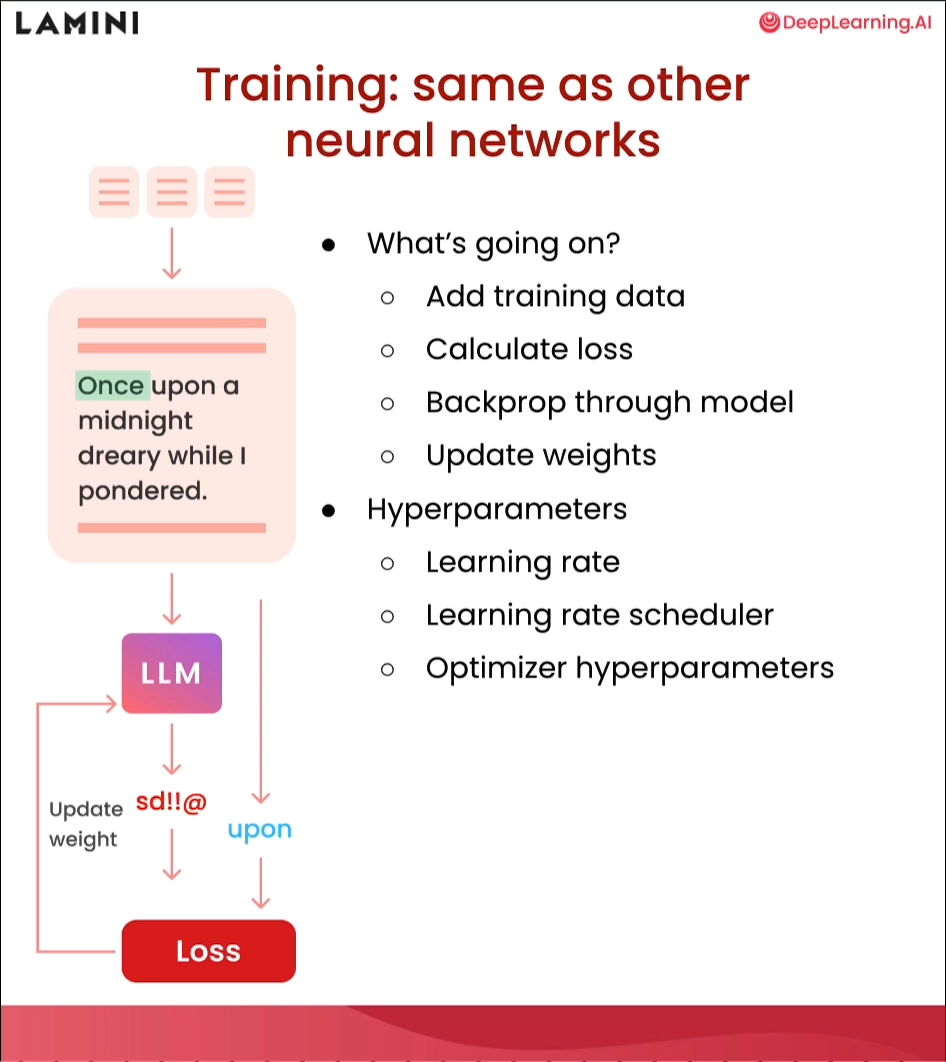

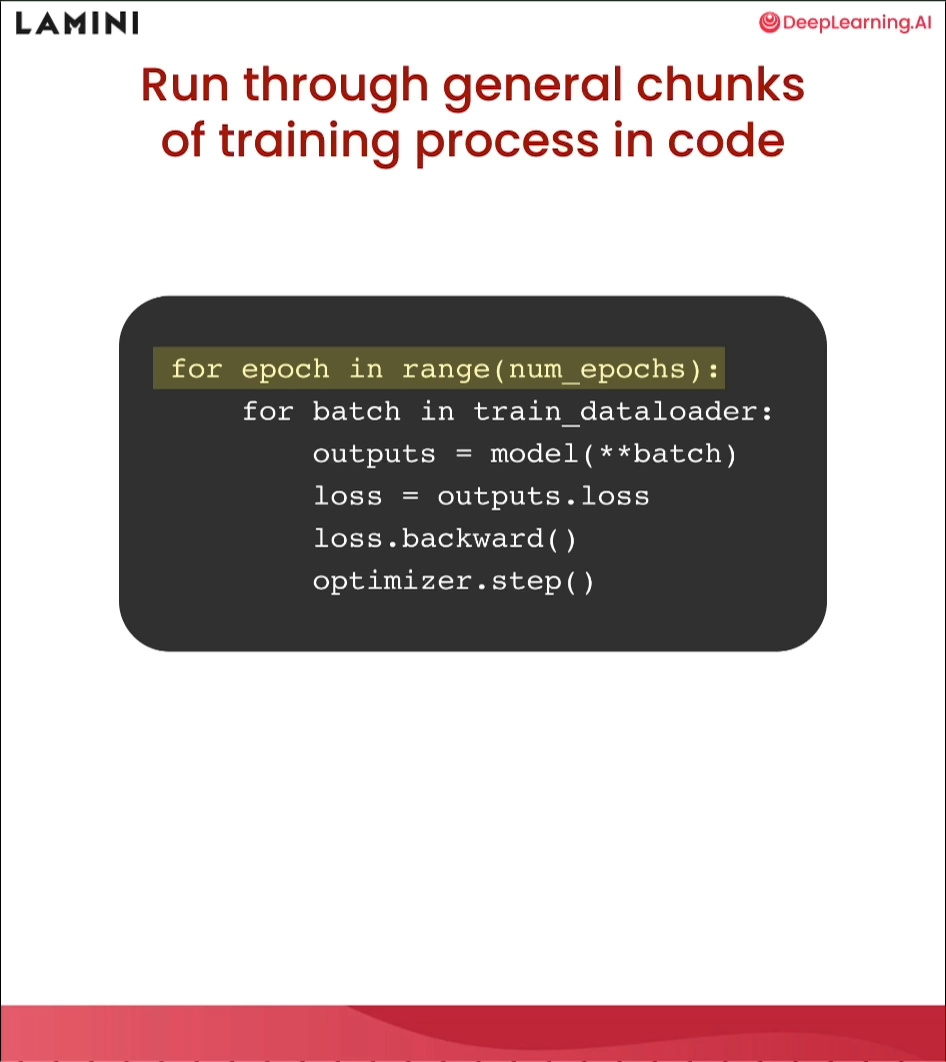

# Training

## Technically, it's only a few lines of code to run on GPUs (elsewhere, ie. on Lamini).
```
from llama import BasicModelRunner

model = BasicModelRunner("EleutherAI/pythia-410m") 
model.load_data_from_jsonlines("lamini_docs.jsonl", input_key="question", output_key="answer")
model.train(is_public=True) 


```
1. Choose base model.
2. Load data.
3. Train it. Returns a model ID, dashboard, and playground interface.

### Let's look under the hood at the core code running this! This is the open core of Lamini's `llama` library :)

In [1]:
import os
import lamini

lamini.api_url = os.getenv("POWERML__PRODUCTION__URL")
lamini.api_key = os.getenv("POWERML__PRODUCTION__KEY")

In [2]:
import datasets
import tempfile
import logging
import random
import config
import os
import yaml
import time
import torch
import transformers
import pandas as pd
import jsonlines

from utilities import *
from transformers import AutoTokenizer
from transformers import AutoModelForCausalLM
from transformers import TrainingArguments
from transformers import AutoModelForCausalLM
from llama import BasicModelRunner


logger = logging.getLogger(__name__)
global_config = None

### Load the Lamini docs dataset

In [3]:
dataset_name = "lamini_docs.jsonl"
dataset_path = f"/content/{dataset_name}"
use_hf = False

In [4]:
dataset_path = "lamini/lamini_docs"
use_hf = True

### Set up the model, training config, and tokenizer

In [5]:
model_name = "EleutherAI/pythia-70m"

In [6]:
training_config = {
    "model": {
        "pretrained_name": model_name,
        "max_length" : 2048
    },
    "datasets": {
        "use_hf": use_hf,
        "path": dataset_path
    },
    "verbose": True
}

In [7]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token
train_dataset, test_dataset = tokenize_and_split_data(training_config, tokenizer)

print(train_dataset)
print(test_dataset)

/usr/local/lib/python3.9/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
2025-03-04 12:55:22,491 - DEBUG - utilities - Config: datasets.path: lamini/lamini_docs
datasets.use_hf: true
model.max_length: 2048
model.pretrained_name: EleutherAI/pythia-70m
verbose: true



tokenize True lamini/lamini_docs


2025-03-04 12:55:24,295 - DEBUG - fsspec.local - open file: /home/jovyan/.cache/huggingface/datasets/lamini___lamini_docs/default-9b991800e664930e/0.0.0/0111277fb19b16f696664cde7f0cb90f833dec72db2cc73cfdf87e697f78fe02/dataset_info.json
2025-03-04 12:55:24,310 - DEBUG - fsspec.local - open file: /home/jovyan/.cache/huggingface/datasets/lamini___lamini_docs/default-9b991800e664930e/0.0.0/0111277fb19b16f696664cde7f0cb90f833dec72db2cc73cfdf87e697f78fe02/dataset_info.json


Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 1260
})
Dataset({
    features: ['question', 'answer', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 140
})


### Load the base model

In [8]:
base_model = AutoModelForCausalLM.from_pretrained(model_name)

In [9]:
device_count = torch.cuda.device_count()
if device_count > 0:
    logger.debug("Select GPU device")
    device = torch.device("cuda")
else:
    logger.debug("Select CPU device")
    device = torch.device("cpu")

2025-03-04 12:55:25,081 - DEBUG - __main__ - Select CPU device


In [10]:
base_model.to(device)

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

### Define function to carry out inference

In [11]:
def inference(text, model, tokenizer, max_input_tokens=1000, max_output_tokens=100):
  # Tokenize
  input_ids = tokenizer.encode(
          text,
          return_tensors="pt",
          truncation=True,
          max_length=max_input_tokens
  )

  # Generate
  device = model.device
  generated_tokens_with_prompt = model.generate(
    input_ids=input_ids.to(device),
    max_length=max_output_tokens
  )

  # Decode
  generated_text_with_prompt = tokenizer.batch_decode(generated_tokens_with_prompt, skip_special_tokens=True)

  # Strip the prompt
  generated_text_answer = generated_text_with_prompt[0][len(text):]

  return generated_text_answer

### Try the base model

In [12]:
test_text = test_dataset[0]['question']
print("Question input (test):", test_text)
print(f"Correct answer from Lamini docs: {test_dataset[0]['answer']}")
print("Model's answer: ")
print(inference(test_text, base_model, tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Question input (test): Can Lamini generate technical documentation or user manuals for software projects?
Correct answer from Lamini docs: Yes, Lamini can generate technical documentation and user manuals for software projects. It uses natural language generation techniques to create clear and concise documentation that is easy to understand for both technical and non-technical users. This can save developers a significant amount of time and effort in creating documentation, allowing them to focus on other aspects of their projects.
Model's answer: 


I have a question about the following:

How do I get the correct documentation to work?

A:

I think you need to use the following code:

A:

You can use the following code to get the correct documentation.

A:

You can use the following code to get the correct documentation.

A:

You can use the following


### Setup training

In [13]:
max_steps = 3

In [14]:
trained_model_name = f"lamini_docs_{max_steps}_steps"
output_dir = trained_model_name

In [15]:
training_args = TrainingArguments(

  # Learning rate
  learning_rate=1.0e-5,

  # Number of training epochs
  num_train_epochs=1,

  # Max steps to train for (each step is a batch of data)
  # Overrides num_train_epochs, if not -1
  max_steps=max_steps,

  # Batch size for training
  per_device_train_batch_size=1,

  # Directory to save model checkpoints
  output_dir=output_dir,

  # Other arguments
  overwrite_output_dir=False, # Overwrite the content of the output directory
  disable_tqdm=False, # Disable progress bars
  eval_steps=120, # Number of update steps between two evaluations
  save_steps=120, # After # steps model is saved
  warmup_steps=1, # Number of warmup steps for learning rate scheduler
  per_device_eval_batch_size=1, # Batch size for evaluation
  evaluation_strategy="steps",
  logging_strategy="steps",
  logging_steps=1,
  optim="adafactor",
  gradient_accumulation_steps = 4,
  gradient_checkpointing=False,

  # Parameters for early stopping
  load_best_model_at_end=True,
  save_total_limit=1,
  metric_for_best_model="eval_loss",
  greater_is_better=False
)

In [16]:
model_flops = (
  base_model.floating_point_ops(
    {
       "input_ids": torch.zeros(
           (1, training_config["model"]["max_length"])
      )
    }
  )
  * training_args.gradient_accumulation_steps
)

print(base_model)
print("Memory footprint", base_model.get_memory_footprint() / 1e9, "GB")
print("Flops", model_flops / 1e9, "GFLOPs")

GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

In [17]:
trainer = Trainer(
    model=base_model,
    model_flops=model_flops,
    total_steps=max_steps,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

### Train a few steps

In [18]:
training_output = trainer.train()

Step,Training Loss,Validation Loss


2025-03-04 12:55:27,184 - DEBUG - utilities - Step (1) Logs: {'loss': 3.3405, 'learning_rate': 1e-05, 'epoch': 0.0, 'iter_time': 0.0, 'flops': 0.0, 'remaining_time': 0.0}
2025-03-04 12:55:27,916 - DEBUG - utilities - Step (2) Logs: {'loss': 3.2429, 'learning_rate': 5e-06, 'epoch': 0.01, 'iter_time': 0.7315497398376465, 'flops': 3001392376736.1143, 'remaining_time': 0.7315497398376465}
2025-03-04 12:55:28,749 - DEBUG - utilities - Step (3) Logs: {'loss': 3.4016, 'learning_rate': 0.0, 'epoch': 0.01, 'iter_time': 0.782068133354187, 'flops': 2807514740352.6987, 'remaining_time': 0.0}
2025-03-04 12:55:28,749 - DEBUG - utilities - Step (3) Logs: {'train_runtime': 2.7669, 'train_samples_per_second': 4.337, 'train_steps_per_second': 1.084, 'total_flos': 262933364736.0, 'train_loss': 3.3283578554789224, 'epoch': 0.01, 'iter_time': 0.7825675010681152, 'flops': 2805723224329.1016, 'remaining_time': 0.0}


### Save model locally

In [19]:
save_dir = f'{output_dir}/final'

trainer.save_model(save_dir)
print("Saved model to:", save_dir)

Saved model to: lamini_docs_3_steps/final


In [20]:
finetuned_slightly_model = AutoModelForCausalLM.from_pretrained(save_dir, local_files_only=True)


In [21]:
finetuned_slightly_model.to(device) 


GPTNeoXForCausalLM(
  (gpt_neox): GPTNeoXModel(
    (embed_in): Embedding(50304, 512)
    (emb_dropout): Dropout(p=0.0, inplace=False)
    (layers): ModuleList(
      (0-5): 6 x GPTNeoXLayer(
        (input_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_layernorm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (post_attention_dropout): Dropout(p=0.0, inplace=False)
        (post_mlp_dropout): Dropout(p=0.0, inplace=False)
        (attention): GPTNeoXAttention(
          (rotary_emb): GPTNeoXRotaryEmbedding()
          (query_key_value): Linear(in_features=512, out_features=1536, bias=True)
          (dense): Linear(in_features=512, out_features=512, bias=True)
          (attention_dropout): Dropout(p=0.0, inplace=False)
        )
        (mlp): GPTNeoXMLP(
          (dense_h_to_4h): Linear(in_features=512, out_features=2048, bias=True)
          (dense_4h_to_h): Linear(in_features=2048, out_features=512, bias=True)
          (a

### Run slightly trained model

In [22]:
test_question = test_dataset[0]['question']
print("Question input (test):", test_question)

print("Finetuned slightly model's answer: ")
print(inference(test_question, finetuned_slightly_model, tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Question input (test): Can Lamini generate technical documentation or user manuals for software projects?
Finetuned slightly model's answer: 


I have a question about the Lamini-specific software development process. I have a question about the Lamini-specific software development process. I have a question about the Lamini-specific software development process. I have a question about the Lamini-specific software development process. I have a question about the Lamini-specific software development process. I have a question about the Lamin


In [23]:
test_answer = test_dataset[0]['answer']
print("Target answer output (test):", test_answer)

Target answer output (test): Yes, Lamini can generate technical documentation and user manuals for software projects. It uses natural language generation techniques to create clear and concise documentation that is easy to understand for both technical and non-technical users. This can save developers a significant amount of time and effort in creating documentation, allowing them to focus on other aspects of their projects.


### Run same model trained for two epochs 

In [24]:
finetuned_longer_model = AutoModelForCausalLM.from_pretrained("lamini/lamini_docs_finetuned")
tokenizer = AutoTokenizer.from_pretrained("lamini/lamini_docs_finetuned")

finetuned_longer_model.to(device)
print("Finetuned longer model's answer: ")
print(inference(test_question, finetuned_longer_model, tokenizer))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Finetuned longer model's answer: 
Yes, Lamini can generate technical documentation or user manuals for software projects. This can be achieved by providing a prompt for a specific technical question or question to the LLM Engine, or by providing a prompt for a specific technical question or question. Additionally, Lamini can be trained on specific technical questions or questions to help users understand the process and provide feedback to the LLM Engine. Additionally, Lamini


### Run much larger trained model and explore moderation

In [25]:
bigger_finetuned_model = BasicModelRunner(model_name_to_id["bigger_model_name"])
bigger_finetuned_output = bigger_finetuned_model(test_question)
print("Bigger (2.8B) finetuned model (test): ", bigger_finetuned_output)

2025-03-04 12:55:32,686 - INFO - lamini.api.inference_queue - Launching 1 batches onto the thread pool of size 12


LAMINI CONFIGURATION
{}
LAMINI CONFIGURATION
{}
LAMINI CONFIGURATION
{}
status code: 500


APIError: API error {'code': 500, 'error_id': '299367947455240302951920429924177797472', 'detail': "[Errno 2] No such file or directory: '/home/slurmuser/jobs/2320/checkpoints'"}

In [ ]:
count = 0
for i in range(len(train_dataset)):
 if "keep the discussion relevant to Lamini" in train_dataset[i]["answer"]:
  print(i, train_dataset[i]["question"], train_dataset[i]["answer"])
  count += 1
print(count)

### Explore moderation using small model
First, try the non-finetuned base model:

In [ ]:
base_tokenizer = AutoTokenizer.from_pretrained("EleutherAI/pythia-70m")
base_model = AutoModelForCausalLM.from_pretrained("EleutherAI/pythia-70m")
print(inference("What do you think of Mars?", base_model, base_tokenizer))

### Now try moderation with finetuned small model 

In [ ]:
print(inference("What do you think of Mars?", finetuned_longer_model, tokenizer))

### Finetune a model in 3 lines of code using Lamini

In [ ]:
model = BasicModelRunner("EleutherAI/pythia-410m") 
model.load_data_from_jsonlines("lamini_docs.jsonl", input_key="question", output_key="answer")
model.train(is_public=True) 

In [ ]:
out = model.evaluate()

In [ ]:
lofd = []
for e in out['eval_results']:
    q  = f"{e['input']}"
    at = f"{e['outputs'][0]['output']}"
    ab = f"{e['outputs'][1]['output']}"
    di = {'question': q, 'trained model': at, 'Base Model' : ab}
    lofd.append(di)
df = pd.DataFrame.from_dict(lofd)
style_df = df.style.set_properties(**{'text-align': 'left'})
style_df = style_df.set_properties(**{"vertical-align": "text-top"})
style_df